# **JLNN as an alternative to PyReason**

PyReason is a powerful tool for logical reasoning over graphs, but it operates
primarily with static rules. JLNN introduces 'Differentiable Logic,' which allows:
1. Learning Rule Strengths: How much does having a 'cool car' actually impact popularity?
2. Learning Semantic Boundaries: What exactly defines a 'cool car' for this specific dataset?
3. Neural Integration: JLNN can be trained via backpropagation, making it
   compatible with modern ML pipelines.

## **1. Installation and automatic restart**

V Google Colab stačí balíček nainstalovat přímo z GitHubu. Protože jsou exportní nástroje integrované, nejsou potřeba žádné další parametry.

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import optuna
    import matplotlib.pyplot as plt
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install optuna optuna-dashboard pandas scikit-learn matplotlib
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    !pip install  scikit-learn pandas

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take

### ***Library imports***

In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jlnn.symbolic.compiler import LNNFormula
from jlnn.training.losses import total_lnn_loss

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)   # keep output clean

from sklearn.metrics import accuracy_score

#### *Add this to verify JAX is using the GPU if available*

In [2]:
print(f"JAX Device: {jax.devices()[0]}")

JAX Device: TFRT_CPU_0


## **2. Social Graph Creation**

Small chart: 8 people, friendship, pet and car ownership

In [3]:
G = nx.Graph()

#### ***People***

In [4]:
people = ["Alice", "Bob", "Charlie", "Dana", "Eve", "Frank", "Grace", "Hank"]
G.add_nodes_from(people)

#### ***Friendship (edges)***

In [5]:
friendships = [
    ("Alice", "Bob"), ("Alice", "Charlie"), ("Bob", "Dana"),
    ("Charlie", "Eve"), ("Dana", "Frank"), ("Eve", "Grace"),
    ("Frank", "Hank"), ("Grace", "Hank"), ("Bob", "Eve")
]
G.add_edges_from(friendships)
node_list = list(G.nodes())

#### ***Ownership of animals and cars (node ​​attributes)***

In [6]:
pet_scores_dict = {"Alice": 0.8, "Bob": 0.3, "Charlie": 0.9, "Dana": 0.4,
                   "Eve": 0.7,   "Frank": 0.2, "Grace": 0.85, "Hank": 0.6}

In [7]:
car_scores_dict = {"Alice": 0.6, "Bob": 0.9, "Charlie": 0.4, "Dana": 0.8,
                   "Eve": 0.5,   "Frank": 0.95, "Grace": 0.7, "Hank": 0.3}

In [8]:
nx.set_node_attributes(G, pet_scores_dict, "pet_score")
nx.set_node_attributes(G, car_scores_dict, "car_score")

####  ***JAX arrays indexed in node_list order – used everywhere below***

In [9]:
pet_scores = jnp.array([pet_scores_dict[n] for n in node_list])
car_scores = jnp.array([car_scores_dict[n] for n in node_list])
adj_matrix = jnp.array(nx.to_numpy_array(G))

### ***Graph visualization***

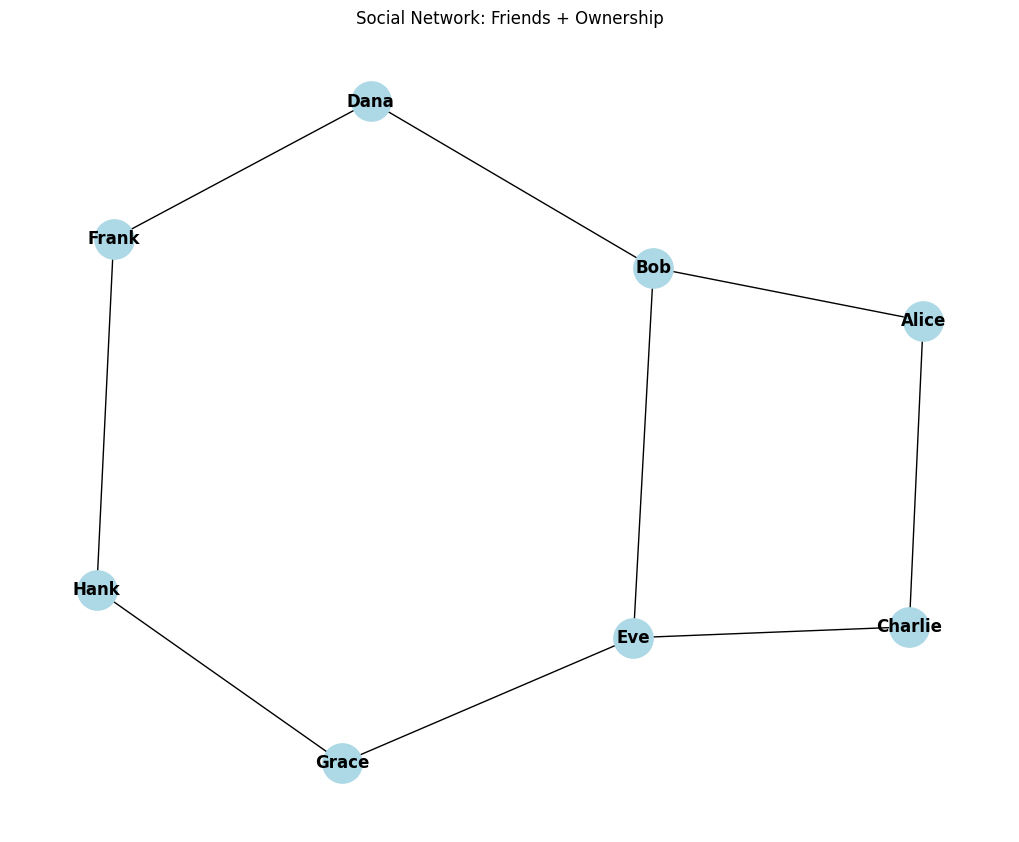

In [10]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=800, font_weight="bold")
plt.title("Social Network: Friends + Ownership")
plt.show()

## **3. Trainable fuzzy grounding (like nnx.Module)**
Sigmoid grounding turns a raw score into a fuzzy membership value. <br>
center and steep are learnable, allowing the model to discover what <br>
"cool pet / cool car" means for this specific dataset.

In [11]:
class TrainableFuzzy(nnx.Module):
    def __init__(self, name: str, init_center: float = 0.5, init_steep: float = 10.0):
        self.name = name
        self.center = nnx.Param(jnp.array([init_center]))
        self.steep  = nnx.Param(jnp.array([init_steep]))

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        return 1.0 / (1.0 + jnp.exp(-jnp.abs(self.steep) * (x - self.center)))

## **4. Target popularity (simulated ground truth)**
Popularity ∝ normalised degree + pet bonus + car bonus.

In [12]:
degree     = dict(G.degree())
max_degree = max(degree.values())
popularity = {
    n: degree[n] / max_degree
       + 0.3 * pet_scores_dict[n]
       + 0.2 * car_scores_dict[n]
    for n in G.nodes()
}
popularity = {n: float(np.clip(v, 0.0, 1.0)) for n, v in popularity.items()}

## **5. EXPERIMENT A – Single-rule prototype**
Rule: (has_cool_pet & has_cool_car) -> is_trendy

In [13]:
print("\n" + "="*60)
print("EXPERIMENT A: Single-rule prototype")
print("="*60)


EXPERIMENT A: Single-rule prototype


### ***A1. Model definition***

In [14]:
rule_A = "0.92 :: (has_cool_pet & has_cool_car) -> is_trendy"
logic_A = LNNFormula(rule_A, rngs=nnx.Rngs(42))

In [15]:
class GraphLNN_A(nnx.Module):
    """Single-rule LNN with fuzzy grounding.

    Rule: (has_cool_pet & has_cool_car) -> is_trendy

    LNNFormula always expects a dict[str, jnp.ndarray] where each value has
    shape (batch, 2) representing a truth interval [lower, upper].
    Passing a raw tensor causes a JAX string-indexing TypeError.
    """

    def __init__(self, logic_model):
        self.logic = logic_model
        self.c_pet  = nnx.Param(jnp.array([0.5]))
        self.c_car  = nnx.Param(jnp.array([0.5]))
        self.steep  = nnx.Param(jnp.array([10.0]))

    def __call__(self, pet_val, car_val, adj):
        n = pet_val.shape[0]

        # Fuzzy grounding → scalar membership per node
        pet_f = 1.0 / (1.0 + jnp.exp(-jnp.abs(self.steep) * (pet_val - self.c_pet)))
        car_f = 1.0 / (1.0 + jnp.exp(-jnp.abs(self.steep) * (car_val - self.c_car)))

        # Wrap scalars into [lower, upper] interval tensors of shape (n, 2).
        # A small epsilon gap keeps the interval non-degenerate.
        pet_b = jnp.stack([pet_f, pet_f + 0.01], axis=-1)   # (n, 2)
        car_b = jnp.stack([car_f, car_f + 0.01], axis=-1)   # (n, 2)

        # Maximally uncertain interval for the consequent prior
        unknown = jnp.tile(jnp.array([0.0, 1.0]), (n, 1))   # (n, 2)

        # FIX: pass a dict with string keys – LNNFormula looks up literals by name.
        # friend_f is NOT included here; this rule only has two antecedent literals.
        # Graph diffusion is handled in Experiment B via the two-rule architecture.
        inputs = {
            "has_cool_pet": pet_b,
            "has_cool_car": car_b,
            "is_trendy":    unknown,
        }
        return self.logic(inputs)   # (n, 2)


### ***A2. Training***

In [16]:
graph_model_A = GraphLNN_A(logic_A)
optimizer_A   = nnx.Optimizer(graph_model_A, optax.adamw(0.01), wrt=nnx.Param)

### ***Targets: simple average of pet+car scores as lower bound, +0.05 upper bound.***

In [17]:
targets_A = jnp.stack(
    [pet_scores * 0.5 + car_scores * 0.5,
     pet_scores * 0.5 + car_scores * 0.5 + 0.05],
    axis=1,
)

In [18]:
@nnx.jit
def train_step_A(m, opt, p_data, c_data, adj, targets):
    def loss_fn(model_ptr):
        # LNNFormula returns (n_nodes, n_literals, 2):
        #   axis-1 index 0 = antecedent (has_cool_pet & has_cool_car)
        #   axis-1 index 1 = consequent (is_trendy)  ← this is what we train against
        preds = model_ptr(p_data, c_data, adj)   # (8, 2, 2)
        return total_lnn_loss(preds[:, 1, :], targets, contradiction_weight=2.0)
    loss, grads = nnx.value_and_grad(loss_fn)(m)
    opt.update(m, grads)
    return loss

In [19]:
print("Training Experiment A...")
for step in range(1001):
    loss_A = train_step_A(graph_model_A, optimizer_A,
                          pet_scores, car_scores, adj_matrix, targets_A)
    if step % 250 == 0:
        print(f"  Step {step:4d} | Loss: {loss_A:.6f}")

Training Experiment A...
  Step    0 | Loss: 0.135469
  Step  250 | Loss: 0.008555
  Step  500 | Loss: 0.008555
  Step  750 | Loss: 0.008555
  Step 1000 | Loss: 0.008555


## **6. EXPERIMENT B – Two-rule graph diffusion**
Rule 1: (has_cool_pet & has_cool_car)   -> is_trendy_local <br>
Rule 2: (is_friend   & is_trendy_local) -> is_trendy_social

In [20]:
print("\n" + "="*60)
print("EXPERIMENT B: Two-rule graph diffusion")
print("="*60)


EXPERIMENT B: Two-rule graph diffusion


### ***B1. Model definition***

In [21]:
class GraphLNN_B(nnx.Module):
    """Two-rule LNN: local trendiness propagated through the friendship graph."""

    def __init__(self):
        self.rule_local  = LNNFormula(
            "0.92 :: (has_cool_pet & has_cool_car) -> is_trendy_local",  nnx.Rngs(42))
        self.rule_social = LNNFormula(
            "0.85 :: (is_friend & is_trendy_local) -> is_trendy_social", nnx.Rngs(43))

        self.c_pet  = nnx.Param(jnp.array([0.5]))
        self.c_car  = nnx.Param(jnp.array([0.5]))
        self.steep  = nnx.Param(jnp.array([12.0]))

    def __call__(self, pet_val, car_val, adj):
        batch_size = pet_val.shape[0]
        # Maximally uncertain interval [0, 1] – used as consequent prior.
        unknown = jnp.tile(jnp.array([0.0, 1.0]), (batch_size, 1))   # (n, 2)

        # 1. Fuzzy grounding → interval beliefs
        pet_f  = 1.0 / (1.0 + jnp.exp(-jnp.abs(self.steep) * (pet_val - self.c_pet)))
        car_f  = 1.0 / (1.0 + jnp.exp(-jnp.abs(self.steep) * (car_val - self.c_car)))
        pet_b  = jnp.stack([pet_f,  pet_f  + 0.01], axis=-1)   # (n, 2)
        car_b  = jnp.stack([car_f,  car_f  + 0.01], axis=-1)   # (n, 2)

        # 2. Rule 1 – local trendiness
        inputs1 = {
            "has_cool_pet":   pet_b,
            "has_cool_car":   car_b,
            "is_trendy_local": unknown,
        }
        local_trendy_full = self.rule_local(inputs1)     # (n, 3, 2): [antecedent_and, pet, car, consequent]
        local_trendy = local_trendy_full[:, 2, :]          # (n, 2): consequent is_trendy_local only

        # 3. Graph diffusion – average neighbour belief
        # adj: (n, n), local_trendy: (n, 2) → friend_sum: (n, 2)
        friend_sum   = jnp.matmul(adj, local_trendy)
        friend_count = jnp.sum(adj, axis=1, keepdims=True)          # (n, 1)
        friend_b     = friend_sum / jnp.where(friend_count > 0, friend_count, 1.0)

        # 4. Rule 2 – social trendiness
        inputs2 = {
            "is_friend":        friend_b,
            "is_trendy_local":  local_trendy,
            "is_trendy_social": unknown,
        }
        return self.rule_social(inputs2)   # (n, 2)

### ***B2. Training***

In [22]:
model_B     = GraphLNN_B()
optimizer_B = nnx.Optimizer(model_B, optax.adamw(0.02), wrt=nnx.Param)

normalise the neighbour-score term properly (divide by degree, not a magic constant), then clip the whole target to [0, 1]

In [23]:
degree_vec   = jnp.sum(adj_matrix, axis=1)                        # (n,)
safe_degree  = jnp.where(degree_vec > 0, degree_vec, 1.0)
neigh_pet    = jnp.matmul(adj_matrix, pet_scores) / safe_degree   # mean neighbour pet score

In [24]:
target_val      = pet_scores * 0.4 + car_scores * 0.2 + neigh_pet * 0.4
target_val      = jnp.clip(target_val, 0.0, 1.0)                  # FIX: clip to valid range
target_interval = jnp.stack([target_val, target_val + 0.05], axis=1)

In [25]:
@nnx.jit
def train_step_B(m, opt, p_data, c_data, adj, targets):
    def loss_fn(model_ptr):
        # rule_social has 3 literals: is_friend, is_trendy_local, is_trendy_social
        # LNNFormula output shape: (n_nodes, n_literals, 2) = (8, 3, 2)
        #   index 0 = is_friend
        #   index 1 = is_trendy_local
        #   index 2 = is_trendy_social  ← consequent, train against this
        preds = model_ptr(p_data, c_data, adj)   # (8, 3, 2)
        return total_lnn_loss(preds[:, 2, :], targets, contradiction_weight=3.0)
    loss, grads = nnx.value_and_grad(loss_fn)(m)
    opt.update(m, grads)
    return loss

In [26]:
print("Training Experiment B...")
for step in range(1201):
    loss_B = train_step_B(model_B, optimizer_B,
                          pet_scores, car_scores, adj_matrix, target_interval)
    if step % 300 == 0:
        print(f"  Step {step:4d} | Loss: {loss_B:.6f}")

Training Experiment B...
  Step    0 | Loss: 0.157878
  Step  300 | Loss: 0.157878
  Step  600 | Loss: 0.157878
  Step  900 | Loss: 0.157878
  Step 1200 | Loss: 0.157878


### ***B3. Visualisation***

In JAX, simply call the model normally outside a gradient context – no wrapper is needed.

In [27]:
final_preds  = model_B(pet_scores, car_scores, adj_matrix)  # (8, 3, 2)
trendy_lower = np.array(final_preds[:, 2, 0])               # consequent lower bound → colour

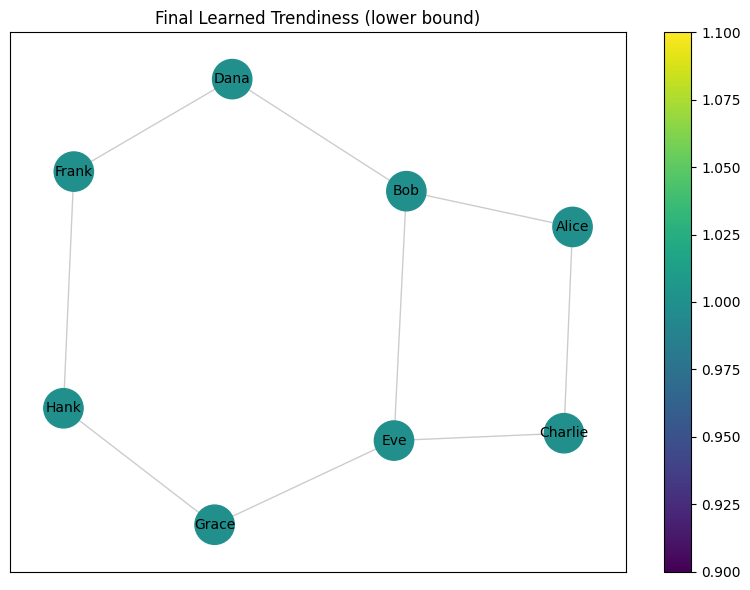

In [28]:
plt.figure(figsize=(8, 6))
pos   = nx.spring_layout(G, seed=42)
nodes = nx.draw_networkx_nodes(G, pos, node_color=trendy_lower,
                               cmap="viridis", node_size=800)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Final Learned Trendiness (lower bound)")
plt.colorbar(nodes)
plt.tight_layout()
plt.show()


## **7. EXPERIMENT C – Optuna hyperparameter search over fuzzy boundary + rule weights**
Idea: instead of hand-picked centers / steepness / rule weights, let Optuna <br>
find the best combination via black-box optimisation.  Inside each trial we <br>
run a short JAX gradient-descent loop (pure pytree, no nnx.Module) and return <br>
the classification accuracy as the objective.

In [29]:
print("\n" + "="*60)
print("EXPERIMENT C: Optuna hyperparameter search")
print("="*60)


EXPERIMENT C: Optuna hyperparameter search


### ***C1. Ground truth & shared data***

Simulated popularity labels (Alice … Hank in node_list order).

In [30]:
popularity_gt = jnp.array([0.9, 0.8, 0.4, 0.7, 0.3, 0.6, 0.85, 0.55])

In [31]:
degrees_c = jnp.sum(adj_matrix, axis=1) + 1e-6   # avoid div-by-zero

### ***C2. Pure-JAX fuzzy model (no nnx, params are a plain pytree dict)***

In [32]:
def fuzzy_high(x, center, steepness):
    """Sigmoid membership: 1 when x >> center, 0 when x << center."""
    return 1.0 / (1.0 + jnp.exp(-steepness * (x - center)))

In [33]:
def aggregate_friends(popularity, adj, deg):
    """Weighted-average popularity of graph neighbours."""
    return jnp.matmul(adj, popularity) / deg

In [34]:
def model_forward_c(params, car, pet, adj, deg):
    """
    Returns a [0,1] popularity score for each of the 8 nodes.

    Fuzzy rule: high_car AND high_pet  → direct trendiness
    Propagation: blend direct score with neighbourhood average (2 steps).
    """
    high_car = fuzzy_high(car, params["c_car"],  params["steepness"])
    high_pet = fuzzy_high(pet, params["c_pet"],  params["steepness"])

    # Fuzzy AND = product (differentiable; min is not)
    direct = high_car * high_pet * params["rule_strength"]

    pop = direct
    for _ in range(2):
        pop = (1.0 - params["friend_influence"]) * pop \
            + params["friend_influence"] * aggregate_friends(pop, adj, deg)
    return pop

In [35]:
def loss_c(params, car, pet, adj, deg, gt):
    """MSE + small L2 regularisation on steep / friend_influence."""
    pred = model_forward_c(params, car, pet, adj, deg)
    mse  = jnp.mean((pred - gt) ** 2)
    reg  = 0.01 * (params["steepness"] ** 2 + params["friend_influence"] ** 2)
    return mse + reg

### ***C3. Per-trial training loop***

In [36]:
def train_one_trial(init_params_dict: dict, n_steps: int = 600) -> dict:
    """Run gradient descent for one Optuna trial; return best accuracy + params."""

    # Convert Python scalars → JAX arrays so jax.grad can differentiate through them
    params = {k: jnp.array(float(v)) for k, v in init_params_dict.items()}

    tx    = optax.adam(learning_rate=0.01)
    state = tx.init(params)

    # FIX: argnums=0 → gradient flows into `params`, not into data arrays
    grad_fn = jax.jit(jax.value_and_grad(loss_c, argnums=0))

    best_loss   = float("inf")
    best_params = params   # FIX: initialise so it is always defined

    for _ in range(n_steps):
        loss_val, grads = grad_fn(params, pet_scores, car_scores,
                                  adj_matrix, degrees_c, popularity_gt)
        updates, state  = tx.update(grads, state, params)   # FIX: proper optax update
        params          = optax.apply_updates(params, updates)

        loss_py = float(loss_val)
        if loss_py < best_loss:
            best_loss   = loss_py
            best_params = params

    best_pred = model_forward_c(best_params, pet_scores, car_scores,
                                adj_matrix, degrees_c)
    pred_bin  = (np.array(best_pred) > 0.5).astype(int)
    gt_bin    = (np.array(popularity_gt) > 0.5).astype(int)

    acc = float(accuracy_score(gt_bin, pred_bin))
    return {"best_loss": best_loss, "accuracy": acc, "params": best_params}

### ***C4. Optuna objective***

In [37]:
def objective(trial: optuna.Trial) -> float:
    init_params = {
        "c_car":            trial.suggest_float("c_car",             0.30, 0.80),
        "c_pet":            trial.suggest_float("c_pet",             0.20, 0.70),
        "steepness":        trial.suggest_float("steepness",         5.0,  20.0),
        "rule_strength":    trial.suggest_float("rule_strength",     0.60,  1.00),
        "friend_influence": trial.suggest_float("friend_influence",  0.10,  0.60),
    }
    result = train_one_trial(init_params)
    return result["accuracy"]   # Optuna maximises this

### ***C5. Run study***

In [38]:
study_c = optuna.create_study(direction="maximize",
                              sampler=optuna.samplers.TPESampler(seed=42))
study_c.optimize(objective, n_trials=40, timeout=600, show_progress_bar=False)

In [39]:
print(f"\nBest accuracy : {study_c.best_value:.3f}")
print(f"Best params   : {study_c.best_params}")


Best accuracy : 0.750
Best params   : {'c_car': 0.3917022549267169, 'c_pet': 0.3521211214797688, 'steepness': 12.871346474483568, 'rule_strength': 0.7727780074568463, 'friend_influence': 0.24561457009902096}


### ***C6. Retrain with best params & visualise***

In [40]:
best_result = train_one_trial(study_c.best_params, n_steps=1200)
final_pop   = model_forward_c(best_result["params"], pet_scores, car_scores,
                              adj_matrix, degrees_c)
trendy_c    = np.array(final_pop)

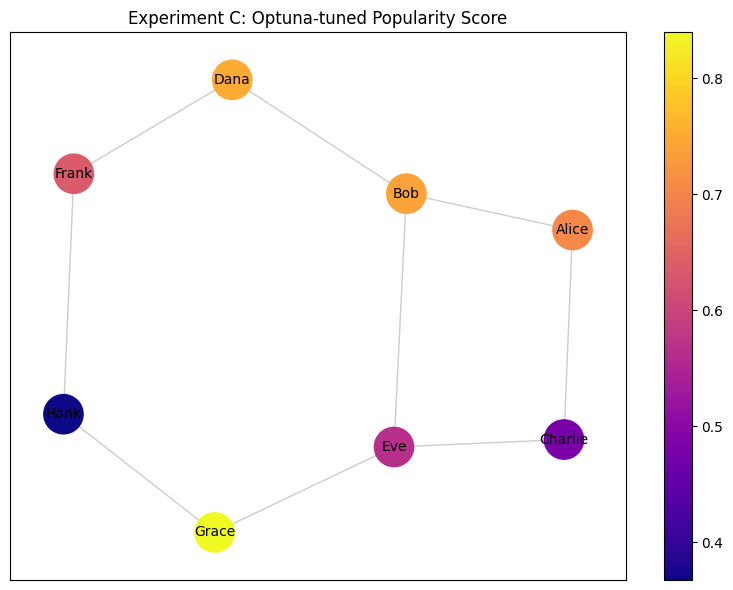

In [41]:
plt.figure(figsize=(8, 6))
nodes_c = nx.draw_networkx_nodes(G, pos, node_color=trendy_c,
                                 cmap="plasma", node_size=800)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Experiment C: Optuna-tuned Popularity Score")
plt.colorbar(nodes_c)
plt.tight_layout()
plt.show()

In [42]:
print("\n✅ All done.")


✅ All done.
